In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Path dataset
dataset_path = 'C:/Users/Parasetamol/Documents/Python/dataset/Jahe'   # Ganti dengan path dataset Anda

In [3]:
# Image Augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
# Load semua gambar dan label
def load_data(dataset_path):
    images = []
    labels = []
    class_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    print(f"Found classes: {class_names}")
    for class_idx, class_name in enumerate(class_names):
        class_folder = os.path.join(dataset_path, class_name)
        print(f"Processing class: {class_name}")
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            if os.path.isfile(img_path):  # Ensure it's a file
                print(f"Loading image: {img_path}")
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                labels.append(class_idx)
    return np.array(images), np.array(labels), class_names

In [5]:
images, labels, class_names = load_data(dataset_path)
print(f"Loaded {len(images)} images across {len(class_names)} classes.")

Found classes: ['Emprit', 'Gajah', 'Merah']
Processing class: Emprit
Loading image: C:/Users/Parasetamol/Documents/Python/dataset/Jahe\Emprit\.trashed-1737951263-IMG20241228012111.jpg
Loading image: C:/Users/Parasetamol/Documents/Python/dataset/Jahe\Emprit\.trashed-1737951263-IMG20241228012123.jpg
Loading image: C:/Users/Parasetamol/Documents/Python/dataset/Jahe\Emprit\.trashed-1737951263-IMG20241228012138.jpg
Loading image: C:/Users/Parasetamol/Documents/Python/dataset/Jahe\Emprit\.trashed-1737951263-IMG20241228012251.jpg
Loading image: C:/Users/Parasetamol/Documents/Python/dataset/Jahe\Emprit\.trashed-1737951263-IMG20241228012258.jpg
Loading image: C:/Users/Parasetamol/Documents/Python/dataset/Jahe\Emprit\.trashed-1737951263-IMG20241228012310.jpg
Loading image: C:/Users/Parasetamol/Documents/Python/dataset/Jahe\Emprit\.trashed-1737951263-IMG20241228012324.jpg
Loading image: C:/Users/Parasetamol/Documents/Python/dataset/Jahe\Emprit\.trashed-1737951263-IMG20241228012345.jpg
Loading ima

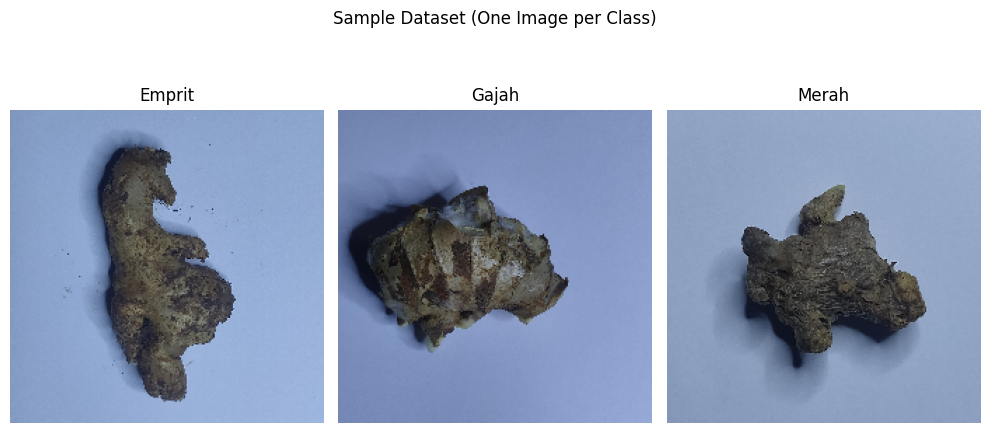

In [6]:
# Visualisasi dataset dengan menampilkan setiap kelas
plt.figure(figsize=(10, 5))

# Ambil gambar pertama dari setiap kelas
for class_idx, class_name in enumerate(class_names):
    class_images = images[labels == class_idx]  # Ambil gambar sesuai kelas
    plt.subplot(1, len(class_names), class_idx + 1)  # Baris 1, kolom sesuai jumlah kelas
    plt.imshow(class_images[0].astype("uint8"))  # Gambar pertama dari kelas
    plt.title(class_name)
    plt.axis("off")

plt.suptitle("Sample Dataset (One Image per Class)")
plt.tight_layout()
plt.show()


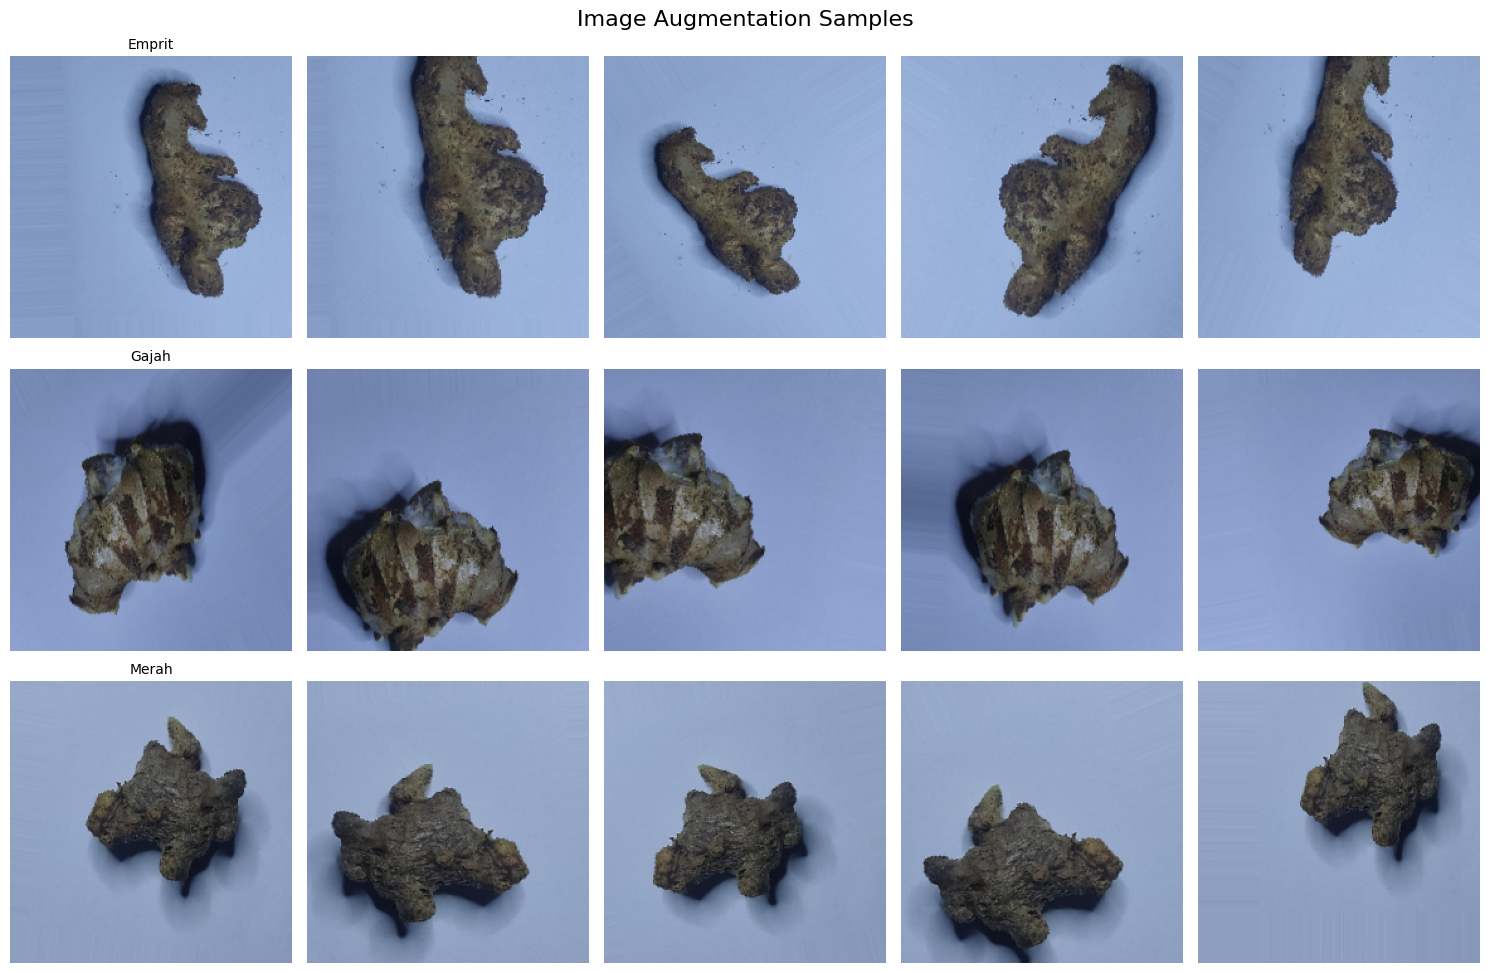

In [7]:
# Visualisasi Data Asli dan Augmentasi dengan Nama Kelas pada Visual
def visualize_augmentation(images, labels, class_names, datagen, num_samples=5):
    plt.figure(figsize=(15, 10))
    for class_idx, class_name in enumerate(class_names):
        # Ambil satu contoh gambar untuk setiap kelas
        class_images = images[labels == class_idx][:1]  # Satu gambar asli
        for i in range(num_samples):
            augmented_image = datagen.random_transform(class_images[0])  # Augmentasi gambar
            plt.subplot(len(class_names), num_samples, class_idx * num_samples + i + 1)
            plt.imshow(augmented_image / 255.0)  # Normalisasi untuk ditampilkan
            plt.axis('off')
            if i == 0:
                plt.title(class_name, fontsize=10)  # Nama kelas di atas gambar
    plt.suptitle("Image Augmentation Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

# Memanggil fungsi visualisasi augmentasi
visualize_augmentation(images, labels, class_names, datagen)

In [8]:
# Konfigurasi Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
# Hasil evaluasi
fold_accuracies = []
all_y_true = []
all_y_pred = []

In [10]:
# Loop melalui setiap fold
for fold, (train_idx, val_idx) in enumerate(kf.split(images, labels)):
    print(f"Training Fold {fold + 1}")
    
    # Split data
    X_train, X_val = images[train_idx], images[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]
    
    # Preprocessing
    y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=len(class_names))
    y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=len(class_names))
    
    # Load model VGG16
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze pretrained layers
    
    # Tambahkan lapisan fully connected
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(class_names), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Training model
    model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), epochs=10, batch_size=32, verbose=1)
    
    # Prediksi pada data validasi
    y_val_pred = model.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    
    # Evaluasi
    acc = accuracy_score(y_val, y_val_pred_classes)
    fold_accuracies.append(acc)
    all_y_true.extend(y_val)
    all_y_pred.extend(y_val_pred_classes)
    print(f"Accuracy Fold {fold + 1}: {acc}")

Training Fold 1
Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5326 - loss: 32.9088 - val_accuracy: 0.8962 - val_loss: 2.5508
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8647 - loss: 2.1774 - val_accuracy: 0.9245 - val_loss: 0.9545
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9245 - loss: 1.1831 - val_accuracy: 0.9623 - val_loss: 0.2791
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9552 - loss: 0.3801 - val_accuracy: 1.0000 - val_loss: 0.0072
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9753 - loss: 0.2622 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9779 - loss: 0.1804 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9730 - loss: 0.2052 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9782 - loss: 0.1460 - val_accuracy: 0

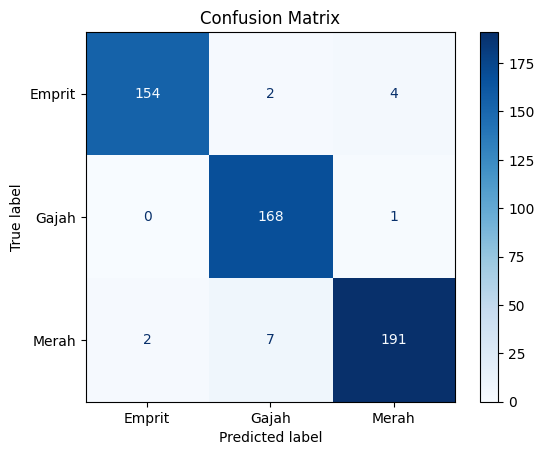

In [11]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [12]:
# Akurasi Total
print(f"Cross-Validation Accuracies: {fold_accuracies}")
print(f"Mean Accuracy: {np.mean(fold_accuracies)}")

Cross-Validation Accuracies: [0.9905660377358491, 0.9433962264150944, 0.9716981132075472, 0.9622641509433962, 0.9809523809523809]
Mean Accuracy: 0.9697753818508537


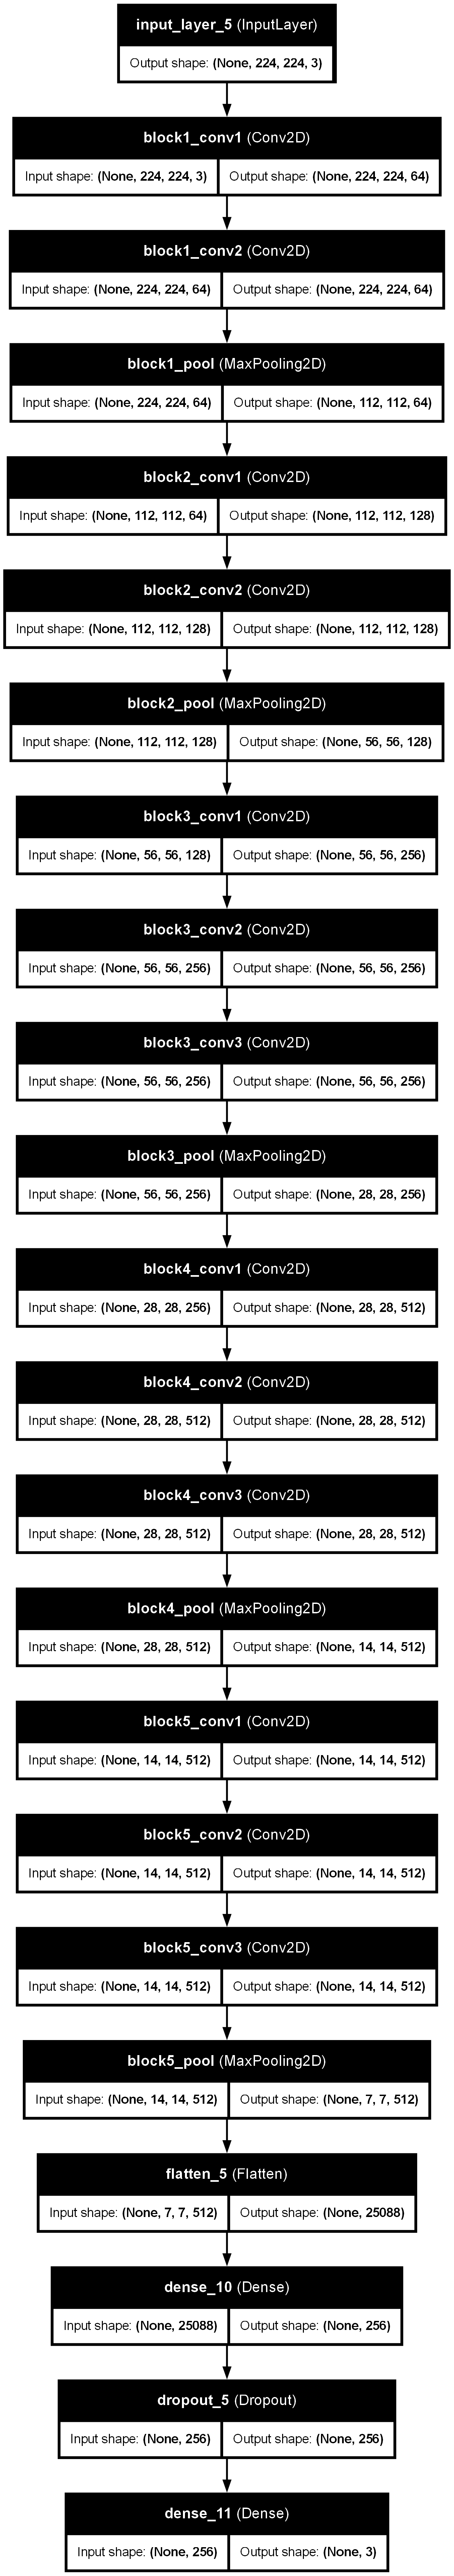

In [13]:
from tensorflow.keras.utils import plot_model

# Buat model VGG16 dengan lapisan tambahan
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze pretrained layers

# Tambahkan lapisan fully connected
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Visualisasi arsitektur model
plot_model(model, to_file='vgg16_model_architecture.png', show_shapes=True, show_layer_names=True)

# Tampilkan gambar hasil visualisasi
from IPython.display import Image
Image('vgg16_model_architecture.png')
